# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [1]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv


Bad key "text.kerning_factor" on line 4 in
C:\Users\fdoba\anaconda3\envs\alpacaenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [150]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [3]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("./Data/sfo_neighborhoods_census_data.csv")
sfo_data = pd.read_csv(file_path, index_col="year")
sfo_data.head()

neighborhood  sale_price_sqr_foot  housing_units  gross_rent
year                                                                  
2010      Alamo Square           291.182945         372560        1239
2010        Anza Vista           267.932583         372560        1239
2010           Bayview           170.098665         372560        1239
2010  Buena Vista Park           347.394919         372560        1239
2010  Central Richmond           319.027623         372560        1239

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [153]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """ok Housing Units Per Year."""
    avg_housing_units_per_year = sfo_data['housing_units'].groupby('year').mean()
    y_min = avg_housing_units_per_year.min() - avg_housing_units_per_year.std()
    y_max = avg_housing_units_per_year.max() + avg_housing_units_per_year.std()
    avg_housing_units_per_year_plot = avg_housing_units_per_year.hvplot.bar(title = 'Housing Units Per Year', ylim = (y_min,y_max), 
                                                                            xlabel='Neighborhoods', ylabel='Avg Sale Price per SQFT', rot=50)
    
    return avg_housing_units_per_year_plot


def average_gross_rent():
    """ok Average Gross Rent in San Francisco Per Year."""
    avg_rent_year = sfo_data['gross_rent'].groupby('year').mean().dropna()
    avg_rent_year_plot = avg_rent_year.hvplot.line(title = 'AVG Rent Price per SQFT by Year', color = 'b')
    
    return avg_rent_year_plot
    
    
def average_sales_price():
    """ok Average Sales Price Per Year."""
    avg_price_sqft_year = sfo_data['sale_price_sqr_foot'].groupby('year').mean().dropna()
    avg_price_sqft_year_plot = avg_price_sqft_year.hvplot.line(title = 'AVG Sales Price per SQFT by Year', color = 'g')
    
    return avg_price_sqft_year_plot
    


def average_price_by_neighborhood():
    """ok Average Prices by Neighborhood."""
    avg_group_year_neighborhood = sfo_data.groupby(by=['year','neighborhood']).mean().dropna()
    avg_group_year_neighborhood = avg_group_year_neighborhood.hvplot.line(x='year',y='sale_price_sqr_foot', 
                                                                          title = "AVG Price per SQFT", groupby='neighborhood')
    
    return avg_group_year_neighborhood
    


def top_most_expensive_neighborhoods():
    """ok Top 10 Most Expensive Neighborhoods."""
    avg_price_sqft = sfo_data[['sale_price_sqr_foot','neighborhood']].groupby('neighborhood').mean()
    top10 = avg_price_sqft.sort_values(by='sale_price_sqr_foot',ascending=False).reset_index().head(10)
    top10_plot = top10.hvplot.bar(title = 'Top 10 Most Expensive Neighborhoods', x='neighborhood',  xlabel='Neighborhoods', 
                                  ylabel='Avg Sale Price per SQFT', rot=50)
    
    return top10_plot


def most_expensive_neighborhoods_rent_sales():
    """ok Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    avg_nb_values = sfo_data.groupby(['year', 'neighborhood']).mean().reset_index()    
    comp_plot = avg_nb_values.hvplot.bar(x='year',y=['sale_price_sqr_foot', 'gross_rent'],xlabel= 'Neighborhood',
                                         ylabel= 'Average Sale Price Per Sqft', rot=50, title='Top 10 expensive neighborhoods in San Francisco',
                                         groupby='neighborhood',height=400
                                        )
    
    comp_plot = pn.pane.HoloViews(comp_plot)
    return comp_plot
    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""
    top10_expensive_neighborhoods = sfo_data.groupby("neighborhood").mean().sort_values("sale_price_sqr_foot", ascending = False).reset_index().iloc[:10]    
    parallel_coordinates_exp = px.parallel_coordinates(top10_expensive_neighborhoods,color = "sale_price_sqr_foot",
                                                       title = "Parallel Coordinates of Most Expensive Neighborhoods")
    
    return parallel_coordinates_exp



def parallel_categories():
    """Parallel Categories Plot."""
    top10_expensive_neighborhoods = sfo_data.groupby("neighborhood").mean().sort_values("sale_price_sqr_foot", ascending = False).reset_index().iloc[:10]
    parallel_categories_exp = px.parallel_categories(top10_expensive_neighborhoods,dimensions = ["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
                                                     color = "sale_price_sqr_foot",title = "Parallel Categories of Most Expensive Neighborhoods")
    
    return parallel_categories_exp



def neighborhood_map():
    """ok Neighborhood Map."""
    # Load neighborhoods coordinates data
    file_path = Path("./Data/neighborhoods_coordinates.csv")
    loc_data = pd.read_csv(file_path, index_col="Neighborhood").reset_index()
    avg_data = sfo_data.groupby('neighborhood').mean().reset_index()
    join = loc_data.join(avg_data).dropna()
    #Creating the scatter mapbox
    map_plot = px.scatter_mapbox(join,lat="Lat",lon="Lon",size="sale_price_sqr_foot",color="gross_rent",zoom=10.5,title='AVG Sale Price Per SQFT and Gross Rent')    
    return map_plot


def sunburst():
    """Sunburst Plot."""    
    avg_values = sfo_data.groupby([sfo_data.index, "neighborhood"]).mean().reset_index()
    top10_expensive_neighborhoods = sfo_data.groupby("neighborhood").mean().sort_values("sale_price_sqr_foot", ascending = False).reset_index().iloc[:10]
    df_exp_neighborhoods_per_year = avg_values[avg_values["neighborhood"].isin(top10_expensive_neighborhoods["neighborhood"])]
    
    neighborhood_sunburst_plot = px.sunburst(df_exp_neighborhoods_per_year,path = ["year", "neighborhood"],values = "sale_price_sqr_foot",
                                             color = "gross_rent",title = "Cost of Most Expensive Neighborhoods")
    
    return neighborhood_sunburst_plot


## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [159]:
# Create a Title for the Dashboard
dashboard_title = "San Francisco's Neighborhoods Dashboard"
dashboard_description = "This dasboard shows an analysis of sales prices and rent from 2010 to 2016 in San Francisco neighborhood"

# Create a tab layout for the dashboard
desc_intro = pn.Column(dashboard_title,dashboard_description)


# Create the dashboard
neighborhood_analysis = pn.Column(average_price_by_neighborhood(),top_most_expensive_neighborhoods(),most_expensive_neighborhoods_rent_sales())
market_analysis_by_year = pn.Column(average_gross_rent(),average_sales_price(),housing_units_per_year())
neighborhood_map_view = pn.Row(neighborhood_map())
parallel_plots_analysis = pn.Column(parallel_coordinates(),parallel_categories())

dashboard = pn.Tabs(
    ("Introduction", desc_intro),
    ("Yearly Analysis", market_analysis_by_year),
    ("Neighborhood Analysis", neighborhood_analysis),
    ("Neighborhood map by Sales and Rent Price",neighborhood_map_view),
    ("Parallel Plots", parallel_plots_analysis)
    
)

## Serve the Panel Dashboard

In [158]:
# Serve the# dashboard
dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Markdown(str)
    [1] Column
        [0] HoloViews(Curve)
        [1] HoloViews(Curve)
        [2] HoloViews(Bars)
    [2] Column
        [0] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
        [1] HoloViews(Bars)
        [2] HoloViews(DynamicMap)
    [3] Row
        [0] Plotly(Figure)
    [4] Column
        [0] Plotly(Figure)
        [1] Plotly(Figure)

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

In [ ]:
#housing_units_per_year()

In [ ]:
# average_gross_rent()

In [ ]:
# average_sales_price()

In [ ]:
# average_price_by_neighborhood()

In [ ]:
# top_most_expensive_neighborhoods()

In [ ]:
# most_expensive_neighborhoods_rent_sales()

In [148]:
#neighborhood_map().show()

In [37]:
#parallel_categories()

In [ ]:
# parallel_coordinates()

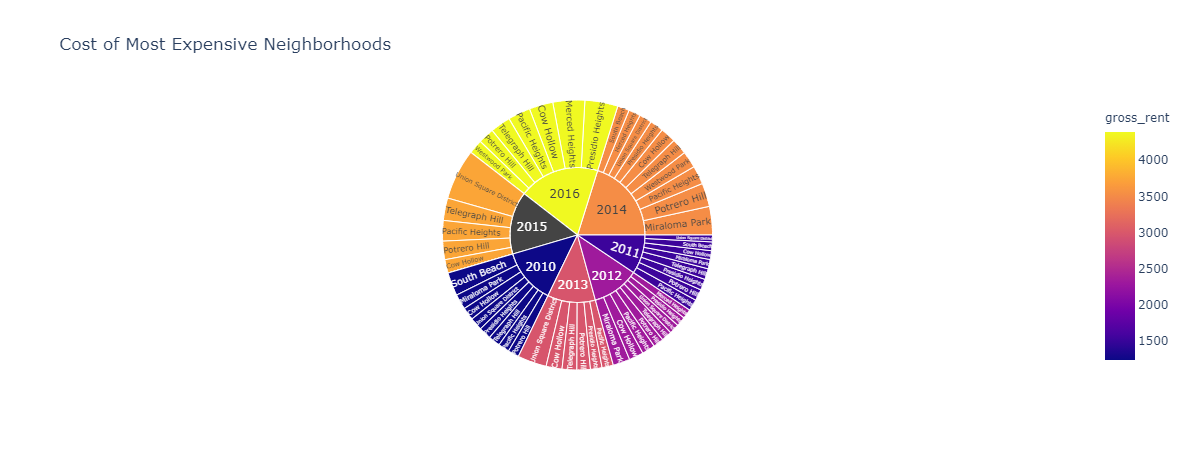

In [149]:
#sunburst()

Data\neighborhoods_coordinates.csv


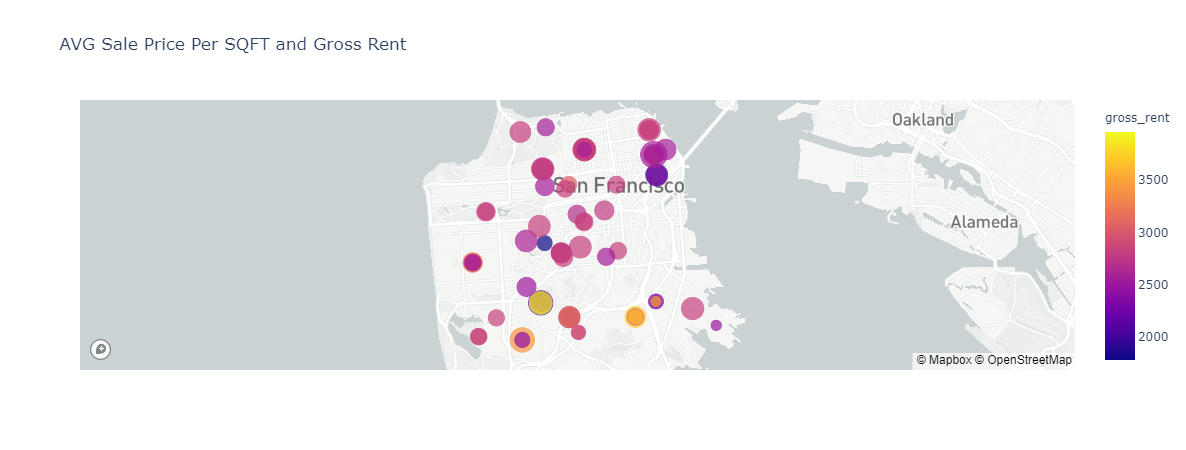

In [125]:
neighborhood_map()